In [1]:
from functools import partial
import graphviz

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pytensor
import pytensor.tensor as pt
import scipy.stats

In [3]:
import numpy as np

import pymc as pm

seed = sum(map(ord, "dims module"))
rng = np.random.default_rng(seed)

In [4]:
# Very realistic looking data!
observed_response_np = np.ones((5, 20), dtype=int)
coords = coords = {
    "participant": range(5),
    "trial": range(20),
    "item": range(3),
}

In [5]:
observed_response_np

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [6]:
with pm.Model(coords=coords) as model:
    observed_response = pm.Data(
        "observed_response", observed_response_np, dims=("participant", "trial")
    )
    # Use ZeroSumNormal to avoid identifiability issues
    participant_preference = pm.ZeroSumNormal(
        "participant_preference", n_zerosum_axes=1, dims=("participant", "item")
    )

    # Shared time effects across all participants
    time_effects = pm.Normal("time_effects", dims=("trial", "item"))

    trial_preference = pm.Deterministic(
        "trial_preference",
        participant_preference[:, None, :] + time_effects[None, :, :],
        dims=("participant", "trial", "item"),
    )

    response = pm.Categorical(
        "response",
        p=pm.math.softmax(trial_preference, axis=-1),
        observed=observed_response,
        dims=("participant", "trial"),
    )

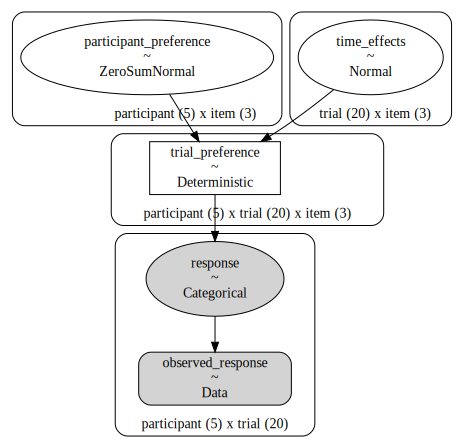

In [7]:
model.to_graphviz()

In [8]:
import pymc.dims as pmd

/usr/local/lib/python3.11/site-packages/pymc/dims/__init__.py:66: UserWarning: The `pymc.dims` module is experimental and may contain critical bugs (p=0.141).
Please report any issues you encounter at https://github.com/pymc-devs/pymc/issues.
API changes are expected in future releases.

  __init__()


In [9]:
with pm.Model(coords=coords) as dmodel:
    observed_response = pmd.Data(
        "observed_response", observed_response_np, dims=("participant", "trial")
    )
    participant_preference = pmd.ZeroSumNormal(
        "participant_preference", core_dims="item", dims=("participant", "item")
    )

    # Shared time effects across all participants
    time_effects = pmd.Normal("time_effects", dims=("item", "trial"))

    trial_preference = pmd.Deterministic(
        "trial_preference",
        participant_preference + time_effects,
    )

    response = pmd.Categorical(
        "response",
        p=pmd.math.softmax(trial_preference, dim="item"),
        core_dims="item",
        observed=observed_response,
    )

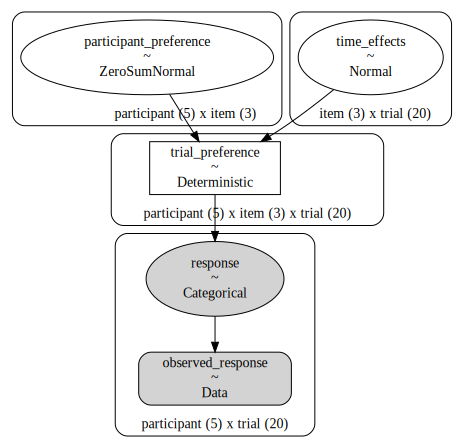

In [10]:
dmodel.to_graphviz()

In [11]:
print(model.point_logps())
print(dmodel.point_logps())

{'participant_preference': np.float64(-9.19), 'time_effects': np.float64(-55.14), 'response': np.float64(-109.86)}
{'participant_preference': np.float64(-9.19), 'time_effects': np.float64(-55.14), 'response': np.float64(-109.86)}


In [12]:
regular_normal = pm.Normal.dist(mu=pm.math.as_tensor([0, 1, 2]), sigma=1, shape=(3,))
regular_normal.type

TensorType(float64, shape=(3,))

In [13]:
type(regular_normal)

pytensor.tensor.variable.TensorVariable

In [14]:
outer_addition = regular_normal[:, None] + regular_normal[None, :]
outer_addition.type

TensorType(float64, shape=(3, 3))

In [15]:
pm.draw(outer_addition, random_seed=rng)

array([[0.61284312, 1.68384684, 1.72225487],
       [1.68384684, 2.75485056, 2.79325859],
       [1.72225487, 2.79325859, 2.83166662]])

In [16]:
dims_normal = pmd.Normal.dist(mu=pmd.math.as_xtensor([0, 1, 2], dims=("a",)), sigma=1)
dims_normal.type

XTensorType(float64, shape=(3,), dims=('a',))

In [17]:
outer_addition = dims_normal + dims_normal.rename({"a": "b"})
outer_addition.type

XTensorType(float64, shape=(3, 3), dims=('a', 'b'))

In [18]:
pm.draw(outer_addition, random_seed=rng)

array([[ 3.76355516,  0.31059132,  6.5420105 ],
       [ 0.31059132, -3.14237253,  3.08904666],
       [ 6.5420105 ,  3.08904666,  9.32046584]])

In [19]:
with pm.Model(coords={"a": range(2), "b": range(5)}) as example:
    x = pmd.Normal("x", dims=("a", "b"))
    det_implicit_dims = pmd.Deterministic("det1", x + 1)
    det_explicit_dims = pmd.Deterministic("det2", x + 1, dims=("a", "b"))
    det_transposed_dims = pmd.Deterministic("y", x + 1, dims=("b", "a"))

print(f"{det_implicit_dims.dims=}")
print(f"{det_explicit_dims.dims=}")
print(f"{det_transposed_dims.dims=}")

det_implicit_dims.dims=('a', 'b')
det_explicit_dims.dims=('a', 'b')
det_transposed_dims.dims=('b', 'a')


In [20]:
with pm.Model(coords={"a": range(2), "b": range(5)}) as example:
    x = pmd.Normal("x", dims=("a", "b"))
    det_ellipsis1 = pmd.Deterministic("det1", x + 1, dims=(...,))
    det_ellipsis2 = pmd.Deterministic("det2", x + 1, dims=(..., "a"))
    det_ellipsis3 = pmd.Deterministic("det3", x + 1, dims=("b", ...))

print(f"{det_ellipsis1.dims=}")
print(f"{det_ellipsis2.dims=}")
print(f"{det_ellipsis3.dims=}")

det_ellipsis1.dims=('a', 'b')
det_ellipsis2.dims=('b', 'a')
det_ellipsis3.dims=('b', 'a')


In [21]:
with pm.Model(coords={"core1": range(3), "core2": range(3), "batch": range(5)}) as mixed_api_model:
    chol, _, _ = pm.LKJCholeskyCov(
        "chol",
        eta=1,
        n=3,
        sd_dist=pm.Exponential.dist(1),
    )
    chol_xr = pmd.as_xtensor(chol, dims=("core1", "core2"))

    mu = pmd.Normal("mu", dims=("batch", "core1"))
    y = pmd.MvNormal(
        "y",
        mu,
        chol=chol_xr,
        core_dims=("core1", "core2"),
    )

print(f"{chol_xr.dims=}")
print(f"{mu.dims=}")
print(f"{y.dims=}")

chol_xr.dims=('core1', 'core2')
mu.dims=('batch', 'core1')
y.dims=('batch', 'core1')


In [22]:
# Simulated data of some spline
N = 500
x_np = np.linspace(0, 10, N)
y_obs_np = np.piecewise(
    x_np,
    [x_np <= 3, (x_np > 3) & (x_np <= 7), x_np > 7],
    [lambda x: 0.5 * x, lambda x: 1.5 + 0.2 * (x - 3), lambda x: 2.3 - 0.1 * (x - 7)],
)
y_obs_np += rng.normal(0, 0.2, size=N)  # Add noise

# Artificial groups
groups = [0, 1, 2]
group_idx_np = np.random.choice(groups, size=N)

n_knots = 50
knots_np = np.linspace(0, 10, num=n_knots)

In [23]:
with pm.Model() as non_vectorized_splines_model:
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=1)

    # Create likelihood per group
    for gr in groups:
        idx = group_idx_np == gr

        beta0 = pm.HalfNormal(f"beta0_{gr}", sigma=sigma_beta0)
        z = pm.Normal(f"z_{gr}", mu=0, sigma=2, shape=n_knots)

        delta_factors = pm.math.softmax(z)
        slope_factors = 1 - pm.math.cumsum(delta_factors[:-1])
        spline_slopes = pm.math.stack(
            [beta0] + [beta0 * slope_factors[i] for i in range(n_knots - 1)]
        )
        beta = pm.Deterministic(
            f"beta_{gr}",
            pm.math.concatenate(([beta0], pm.math.diff(spline_slopes))),
        )

        hinge_terms = [pm.math.maximum(0, x_np[idx] - knot) for knot in knots_np]
        X = pm.math.stack([hinge_terms[i] for i in range(n_knots)], axis=1)

        mu = pm.math.dot(X, beta)

        pm.Normal(f"y_{gr}", mu=mu, sigma=sigma, observed=y_obs_np[idx])

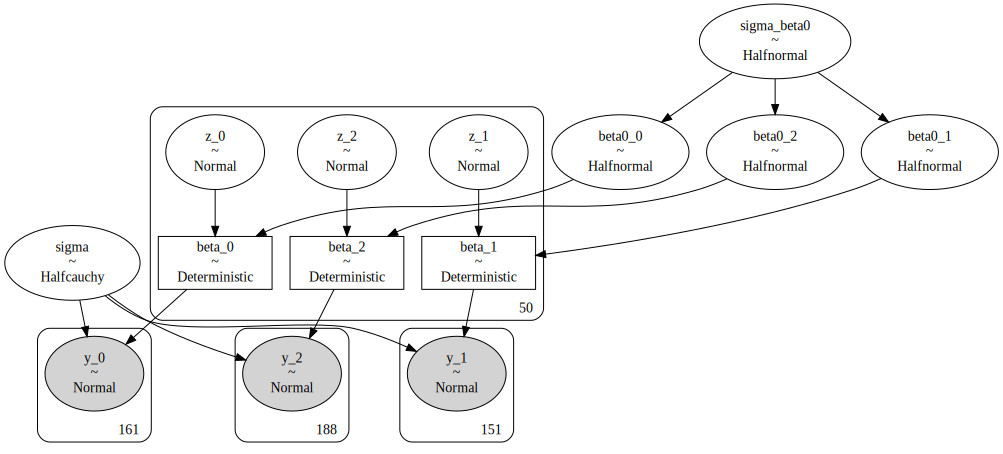

In [24]:
non_vectorized_splines_model.to_graphviz()

In [25]:
coords = {
    "group": range(3),
    "knots": range(n_knots),
    "obs": range(N),
}
with pm.Model(coords=coords) as vectorized_splines_model:
    x = pm.Data("x", x_np, dims="obs")
    y_obs = pm.Data("y_obs", y_obs_np, dims="obs")

    knots = pm.Data("knots", knots_np, dims="knot")

    sigma = pm.HalfCauchy("sigma", beta=1)
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=10)
    beta0 = pm.HalfNormal("beta_0", sigma=sigma_beta0, dims="group")
    z = pm.Normal("z", dims=("group", "knot"))

    delta_factors = pm.math.softmax(z, axis=-1)  # (groups, knot)
    slope_factors = 1 - pm.math.cumsum(delta_factors[:, :-1], axis=-1)  # (groups, knot-1)
    spline_slopes = pm.math.concatenate(
        [beta0[:, None], beta0[:, None] * slope_factors], axis=-1
    )  # (groups, knot-1)
    beta = pm.math.concatenate(
        [beta0[:, None], pm.math.diff(spline_slopes, axis=-1)], axis=-1
    )  # (groups, knot)

    beta = pm.Deterministic("beta", beta, dims=("group", "knot"))

    X = pm.math.maximum(0, x[:, None] - knots[None, :])  # (n, knot)
    mu = (X * beta[group_idx_np]).sum(-1)  # ((n, knots) * (n, knots)).sum(-1) = (n,)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs, dims="obs")

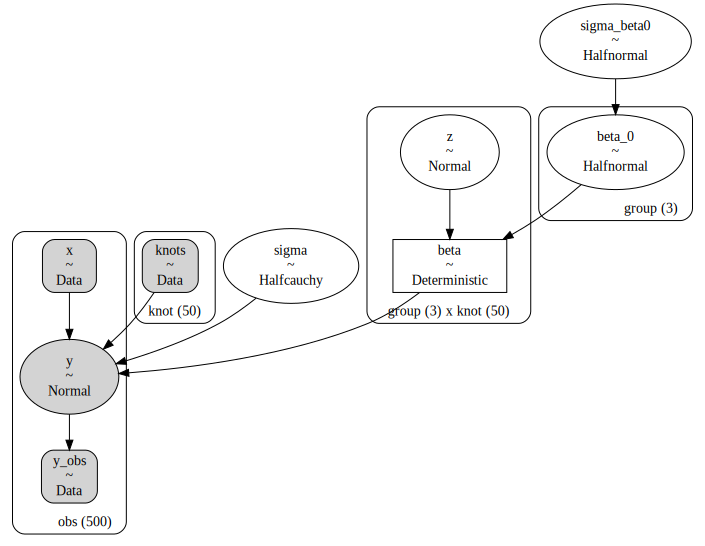

In [26]:
vectorized_splines_model.to_graphviz()

In [27]:
from pytensor.graph import ancestors


def count_nodes(model):
    return len({v for v in ancestors(model.basic_RVs) if v.owner})


print(f"Non-vectorized model has {count_nodes(non_vectorized_splines_model)} nodes")
print(f"Vectorized model has {count_nodes(vectorized_splines_model)} nodes")

Non-vectorized model has 812 nodes
Vectorized model has 38 nodes


In [28]:
with pm.Model(coords=coords) as dims_splines_model:
    x = pmd.Data("x", x_np, dims="obs")
    y_obs = pmd.Data("y_obs", y_obs_np, dims="obs")
    knots = pmd.Data("knots", knots_np, dims=("knot",))
    group_idx = pmd.math.as_xtensor(group_idx_np, dims=("obs",))

    sigma = pmd.HalfCauchy("sigma", beta=1)
    sigma_beta0 = pmd.HalfNormal("sigma_beta0", sigma=10)
    beta0 = pmd.HalfNormal("beta_0", sigma=sigma_beta0, dims=("group",))
    z = pmd.Normal("z", dims=("group", "knot"))

    delta_factors = pmd.math.softmax(z, dim="knot")
    slope_factors = 1 - delta_factors.isel(knot=slice(None, -1)).cumsum("knot")
    spline_slopes = pmd.concat([beta0, beta0 * slope_factors], dim="knot")
    beta = pmd.Deterministic("beta", pmd.concat([beta0, spline_slopes.diff("knot")], dim="knot"))

    X = pmd.math.maximum(0, x - knots)
    mu = (X * beta.isel(group=group_idx)).sum("knot")
    y = pmd.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

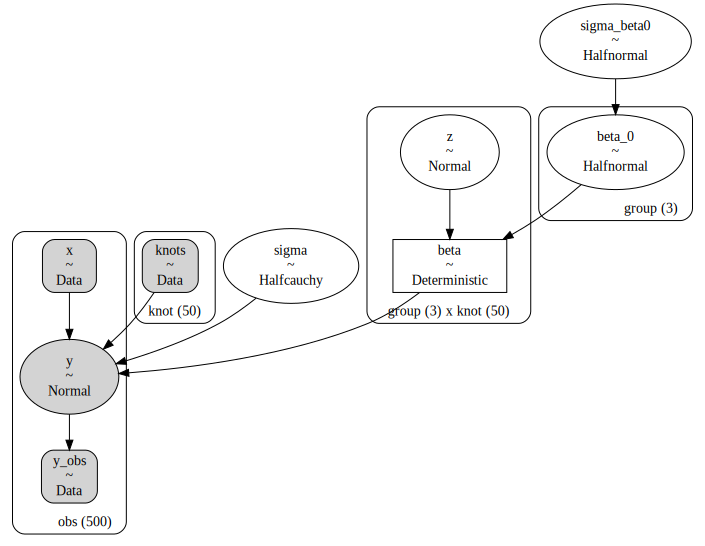

In [29]:
dims_splines_model.to_graphviz()

In [30]:
vectorized_splines_model.point_logps()

{'sigma': np.float64(-1.14),
 'sigma_beta0': np.float64(-0.73),
 'beta_0': np.float64(-2.18),
 'z': np.float64(-137.84),
 'y': np.float64(-319962.47)}

In [31]:
dims_splines_model.point_logps()

{'sigma': np.float64(-1.14),
 'sigma_beta0': np.float64(-0.73),
 'beta_0': np.float64(-2.18),
 'z': np.float64(-137.84),
 'y': np.float64(-319962.47)}

In [32]:
print(f"Vectorized model has {count_nodes(vectorized_splines_model)} nodes")
print(f"Vectorized model with dims has {count_nodes(dims_splines_model)} nodes")

Vectorized model has 38 nodes
Vectorized model with dims has 40 nodes


In [33]:
from xarray import DataArray

x = pm.dims.Normal.dist(dim_lengths={"a": 3})
outer_x = x + x.rename({"a": "b"})
res_numpy = pm.draw(outer_addition)
res_xr = DataArray(res_numpy, dims=outer_addition.dims)
res_xr

<xarray.DataArray (a: 3, b: 3)> Size: 72B
array([[ 2.82128393,  0.65697811,  3.6292314 ],
       [ 0.65697811, -1.50732771,  1.46492558],
       [ 3.6292314 ,  1.46492558,  4.43717887]])
Dimensions without coordinates: a, b

In [34]:
with pm.Model(coords={"a": [-1, 0, 1]}) as m:
    x = pmd.Normal("x", dims=("a",))
    y = pmd.Deterministic("y", x.isel(a=slice(1, None)))
    assert y.dims == ("a",)

    idata = pm.sample_prior_predictive()
idata.prior["y"].coords

Sampling: [x]
/usr/local/lib/python3.11/site-packages/pymc/backends/arviz.py:71: UserWarning: Incompatible coordinate length of 3 for dimension 'a' of variable 'y'.
This usually happens when a sliced or concatenated variable is wrapped as a `pymc.dims.Deterministic`.The originate coordinates for this dim will not be included in the returned dataset for any of the variables. Instead they will default to `np.arange(var_length)` and the shorter variables will be right-padded with nan.
To make this warning into an error set `pymc.backends.arviz.RAISE_ON_INCOMPATIBLE_COORD_LENGTHS` to `True`
  warnings.warn(


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * a        (a) int64 24B 0 1 2

In [35]:
with pm.Model(coords={"a": [-3, -2, -1], "a*": [-2, -1]}) as m:
    x = pmd.Normal("x", dims=("a",))
    y = pmd.Deterministic("y", x.isel(a=slice(1, None)).rename({"a": "a*"}))
    assert y.dims == ("a*",)
    # You can rename back to the original name if you need it for further operations
    y = y.rename({"a*": "a"})

    idata = pm.sample_prior_predictive(draws=1)
idata.prior["y"].coords

Sampling: [x]


Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a*       (a*) int64 16B -2 -1

In [36]:
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a*       (a*) int64 16B -2 -1

SyntaxError: invalid decimal literal (3847396185.py, line 2)

In [37]:
x.isel(a=pmd.math.as_xtensor([0, 1, 2], dims=("a*",))).dims

('a*',)

In [38]:
with pm.Model(coords={"a": [1, 2, 3]}):
    x = pmd.Normal("x", dims=("a",))
    pmd.Deterministic("x_reversed", x[::-1])
    idata = pm.sample_prior_predictive(draws=1)
(idata.prior["x"] - idata.prior["x_reversed"]).values

Sampling: [x]


array([[[-1.00992784,  0.        ,  1.00992784]]])

In [40]:
(idata.prior["x"] - idata.prior["x"].isel(a=slice(None, None, -1))).values

array([[[0., 0., 0.]]])

In [41]:
idata.prior["x_reversed"] = idata.prior["x_reversed"].assign_coords({"a": [3, 2, 1]})
idata.prior["x"] - idata.prior["x_reversed"]

<xarray.DataArray (chain: 1, draw: 1, a: 3)> Size: 24B
array([[[0., 0., 0.]]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8B 0
  * a        (a) int64 24B 1 2 3